In [1]:
# This code is to test a trained dq stepper in the 2d case
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run 2d_lipm_env.ipynb #imports LIPM Env
from py_bullet_env.bullet_bolt_env import BoltBulletEnv

In [2]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        n = 1024
        self.l1 = nn.Linear(inp_size, n)
        self.l2 = nn.Linear(n, n)
        self.l3 = nn.Linear(n, n)
        self.l4 = nn.Linear(n, n)
        self.l5 = nn.Linear(n, n)
        self.l6 = nn.Linear(n, n)
        self.l7 = nn.Linear(n, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = self.l7(x)
        return x

In [3]:
class TwoDQStepper:
    def __init__(self, no_actions = [9, 7], lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 2d dq stepper.
        State = [x-ux, y - uy, xd, yd, n, action_x, action_y]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(7, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(7, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        assert len(no_actions) == 2
        self.no_actions = no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 7))
        self.x_in[:,5] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,6] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
                  
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
        return [action_x, action_y], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
        return [action_x, action_y], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            return [action_x, action_y]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:7].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,7].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,8:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,8:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,8:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.ylim(0, 200)
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

In [4]:
env = TwoDLipmEnv(0.2, 0.13, 0.22, [1, 2, 0], no_actions= [11, 9])
no_actions = [len(env.action_space_x), len(env.action_space_y)]
print(no_actions)

dqs = TwoDQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_2_old')

[11, 9]


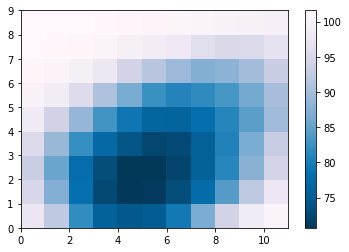

In [5]:
# This block is for visualising the output from the dqstepper
def plot_heatmap(x1, dqs):
    q = dqs.predict_q(x1)
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q)):
        q_mat[int(dqs.x_in[i,6]), int(dqs.x_in[i,5])] = q[i]
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    fig.colorbar(heatmap, ax=ax)
    plt.show()

x1 = [0, 0, 0, 0, -1]
x2 = [0, 0, 1, 0, -1]

plot_heatmap(x1, dqs)
# plot_heatmap(x2, dqs)

In [6]:
# This block animates the stepper 
no_steps = 15
step_time = 0.1
v_init = [0.0, 0.0]
state = env.reset_env([0.0, 0.0, v_init[0], v_init[1]], no_steps*step_time)
epi_cost = 0
for n in range(no_steps):
    action = dqs.predict_action_value(state)[0]
    next_state, cost, done = env.step_env(action, step_time)
    print(action, cost, done)
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
print("showing episode...")
# env.show_episode(5)

[7, 2] 0.7815038737812474 False
[2, 1] 1.7255873308024234 False
[2, 6] 2.8244356932087866 False
[6, 2] 1.136287488027775 False
[7, 5] 1.5460381802775096 False
[3, 2] 1.190823650568739 False
[4, 5] 1.5419278024674188 False
[5, 4] 0.87723148053504 False
[5, 1] 0.833688133081304 False
[3, 3] 1.60682276557263 False
[4, 1] 1.014269417979316 False
[5, 2] 0.7515363390252026 False
[5, 2] 0.6505235579890705 False
[4, 2] 0.629703699241855 False
[5, 4] 1.3316682126302604 False
showing episode...


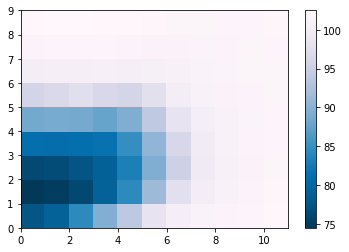

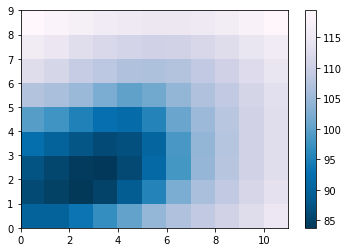

In [154]:
# This block creates the regularizing matrix
no_actions = [len(env.action_space_x), len(env.action_space_y)]
q_mat = np.zeros((no_actions[1], no_actions[0]))
reg_mat = np.zeros((no_actions[1], no_actions[0]))

for y in range(reg_mat.shape[0]):
    for x in range(reg_mat.shape[1]):
        reg_mat[y][x] = np.linalg.norm([env.action_space_x[x], env.action_space_y[y] - env.b])
        
def plot_reg_heatmap(x1, dqs, w):
    q = dqs.predict_q(x1)
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q)):
        q_mat[int(dqs.x_in[i,6]), int(dqs.x_in[i,5])] = q[i]
    q_mat += w*reg_mat
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    fig.colorbar(heatmap, ax=ax)
    plt.show()

x1 = [0, 0, -1, 0, -1]

plot_reg_heatmap(x1, dqs, 0)
plot_reg_heatmap(x1, dqs, 50)


In [5]:
# This block is to test the dq stepper on bolt in pybullet
kp = [100, 100, 100]
kd = [1, 1, 1]
kp_com = [100, 100, 100]
kd_com = [2, 2, 30]
kp_ang_com = [100, 100, 100]
kd_ang_com = [100, 100, 100]

step_time = 0.1
stance_time = 0.01
ht = 0.2

bolt_env = BoltBulletEnv(ht, step_time, stance_time, kp, kd, kp_com, kd_com, kp_ang_com, kd_ang_com)

In [9]:
no_steps = 10
des_com = [0.0, 0, ht]
des_vel = [0, 0, 0]
x_ori = [0, 0, 1, 0]
x_angvel = [0, 0, 0]

x, xd, u, n = bolt_env.reset_env()
state = [x[0] - u[0], x[1] - u[1], xd[0], xd[1], n]
bolt_env.update_gains([100, 100, 25], [1, 1, 1], [0, 0, 0], kd_com, [50, 50, 50], [50, 50, 50])
for i in range(no_steps):
    action = dqs.predict_action_value(state)[0]
    u_x = env.action_space_x[action[0]] + u[0]
    u_y = n*env.action_space_y[action[1]] + u[1]
    x, xd, u_new, n = bolt_env.step_env([u_x, u_y], des_com, des_vel, x_ori, x_angvel)
    print(env.action_space_y[action[1]], u_new[1] - u[1])
    u = u_new
    state = [x[0] - u[0], x[1] - u[1], xd[0], xd[1], n]


0.12 0.12
0.15 -0.14
0.15 0.15000000000000002
0.12 -0.13
0.08 0.11
0.15 -0.16
0.0 -0.009999999999999995
0.12 -0.07
0.04 -0.04000000000000001
0.0 0.12000000000000001


In [14]:
# stepping with regularizing
w = 10.0
q_mat = np.zeros((no_actions[1], no_actions[0]))
reg_mat = np.zeros((no_actions[1], no_actions[0]))
for y in range(reg_mat.shape[0]):
    for x in range(reg_mat.shape[1]):
        reg_mat[y][x] = np.linalg.norm([env.action_space_x[x], env.action_space_y[y] - env.b])

no_steps = 20
des_com = [0.0, 0, ht]
des_vel = [100000.0, 0, 0]
x_ori = [0, 0, 1, 0]
x_angvel = [0, 0, 0]

x, xd, u, n = bolt_env.reset_env()
state = [x[0] - u[0], x[1] - u[1], xd[0], xd[1], n]
bolt_env.update_gains([50, 50, 50], [25, 25, 10], [0, 0, 100], [50, 50, 50], [100, 100, 50], [50, 50, 50])

for i in range(no_steps):
    q = dqs.predict_q(state)
    for i in range(len(q)):
        q_mat[int(dqs.x_in[i,6]), int(dqs.x_in[i,5])] = q[i]
    
    q_mat = q_mat + w*reg_mat
    # Note : index is swapped because x is cols in q_mat    
    action = np.unravel_index(q_mat.argmin(), q_mat.shape)
    u_x = env.action_space_x[action[1]] + u[0]
    u_y = n*env.action_space_y[action[0]] + u[1]
    x, xd, u_new, n = bolt_env.step_env([u_x, u_y], des_com, des_vel, x_ori, x_angvel)
#     print(env.action_space_x[action[1]], np.around(u_new[0] - u[0], 2))
#     print(-n*env.action_space_y[action[0]], u_new[1] - u[1])
    u = u_new
    state = [x[0] - u[0], x[1] - u[1], xd[0], xd[1], n]
